### Imports

In [12]:
import pandas as pd
import seaborn as sns
import sys
import glob
import pathlib
from oak_cli.utils.logging import logger
from icecream import ic

from oak_cli.evaluation.graph_utils import PALETTE, ROUNDING_PRECISION
from oak_cli.evaluation.addons.flops.graph_utils.keys import (
    RUN_ID_KEY,
    CPU_KEY,
    DISK_LAST_KEY,
    DISK_START_KEY,
    MEMORY_KEY,
    NETWORK_LAST_KEYS,
    NETWORK_START_KEYS,
    STAGE_KEY,
    TIME_START_KEY,
    ACCURACY_KEY,
    LOSS_KEY,
)
from oak_cli.evaluation.addons.flops.graph_utils.main import draw_graph, STAGE_ID_KEY, normalize_df_time_ranges
from oak_cli.evaluation.addons.flops.graph_utils.special_graphs import (
    draw_box_violin_plot_for_each_stage,
    draw_line_graph_with_all_runs,
    draw_trained_model_comparison_graph,
)
from oak_cli.evaluation.addons.flops.main import EvaluationRunFLOpsProjectStage
from oak_cli.evaluation.addons.flops.graph_utils.stages import STAGE_DURATIONS_KEY, get_stage_durations_df

### Settings

In [13]:
VERBOSE = True

### Data Loading

In [14]:
#csv_dir = get_csv_dir_for_scenario(EvaluationScenario.FLOPS)
csv_dir = pathlib.Path("/home/alex/oakestra-cli/oak_cli/evaluation/addons/flops/csv/monolith_mnist_sklearn_small_without_baseimages")
#csv_dir = pathlib.Path("/home/alex/oakestra-cli/oak_cli/evaluation/addons/flops/csv/monolith_hierarchical_mnist_sklearn_small_without_baseimages")

csv_files = glob.glob(f'{csv_dir}/evaluation_run_*.csv')
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Add a numerical stage ID (instead of the string) for future numerical manipulations.
df[STAGE_ID_KEY]  =  df[STAGE_KEY].apply(lambda stage_name: EvaluationRunFLOpsProjectStage(stage_name).get_index())

#trained_model_df = pd.read_csv(TRAINED_MODEL_PERFORMANCE_CSV)
trained_model_df = pd.read_csv(csv_dir / "trained_models.csv")

# NOTE: The CSV "time-since-start" values are very precise, thus they differ (slightly) between Evaluation-Runs.
# This difference leads to issues when trying to plot them in an aggregated way.
# To fix this we cast the floats to ints instead. I.e. we are looking at whole seconds - which is fine for this concrete use-case.
df[[TIME_START_KEY]] = round(df[[TIME_START_KEY]].astype(int) / 60, ROUNDING_PRECISION)

df.set_index(TIME_START_KEY, inplace=True)

normalized_df = normalize_df_time_ranges(df)

singular_run_df = df[df[RUN_ID_KEY] == (df[RUN_ID_KEY].max() // 2)]

### Error Handing & Checking

In [15]:
if not csv_dir.exists():
    logger.error(f"{csv_dir} does not exist yet!")
    sys.exit(1)

### Auxiliary

In [16]:
if VERBOSE:
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

### Common Graph Styling

In [17]:
sns.set_style("whitegrid")

---

# Graphs Drawing

### CPU & Memory

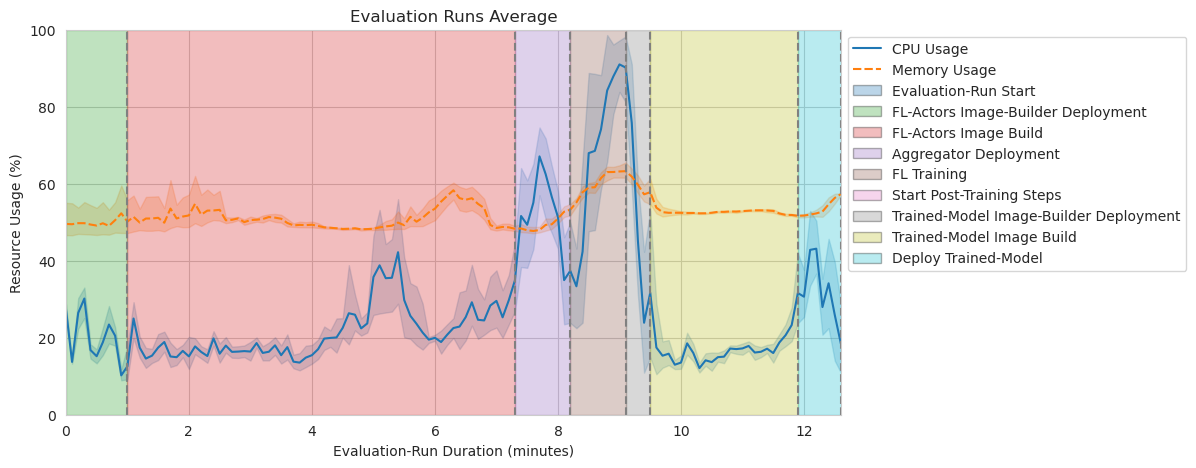

In [18]:
draw_graph(
    title="Evaluation Runs Average",
    data=normalized_df[[CPU_KEY, MEMORY_KEY, STAGE_KEY, RUN_ID_KEY]],
    plot_functions=[
        lambda: sns.lineplot(data=normalized_df[[CPU_KEY, MEMORY_KEY, STAGE_KEY]])
    ],
    use_percentage_limits=True,
    y_label="Resource Usage (%)",
    show_stages=True,
    use_median_stages=True,
)

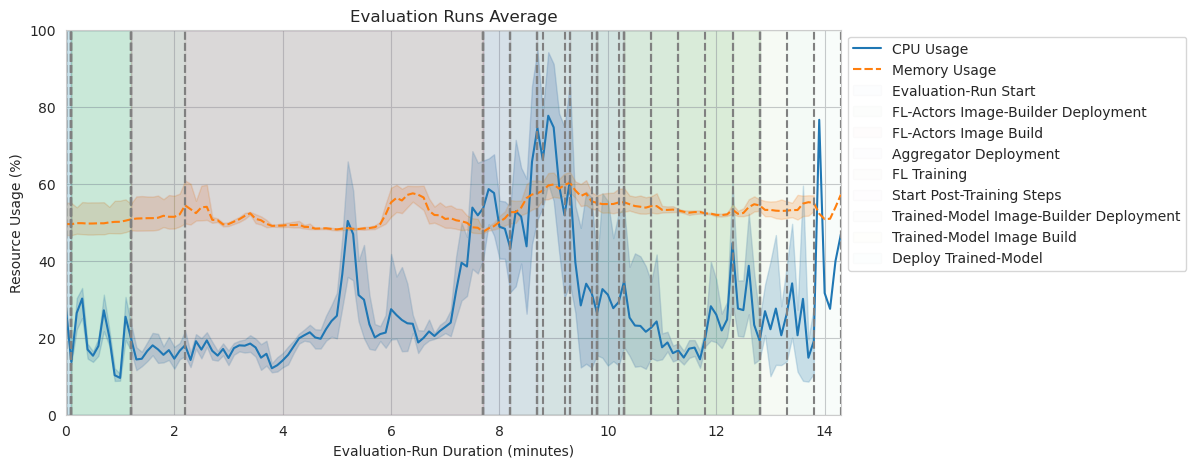

In [19]:
draw_graph(
    title="Evaluation Runs Average",
    data=df[[CPU_KEY, MEMORY_KEY, STAGE_KEY]],
    use_percentage_limits=True,
    y_label="Resource Usage (%)",
    show_stages=True,
    stages_color_intensity=0.01,
)

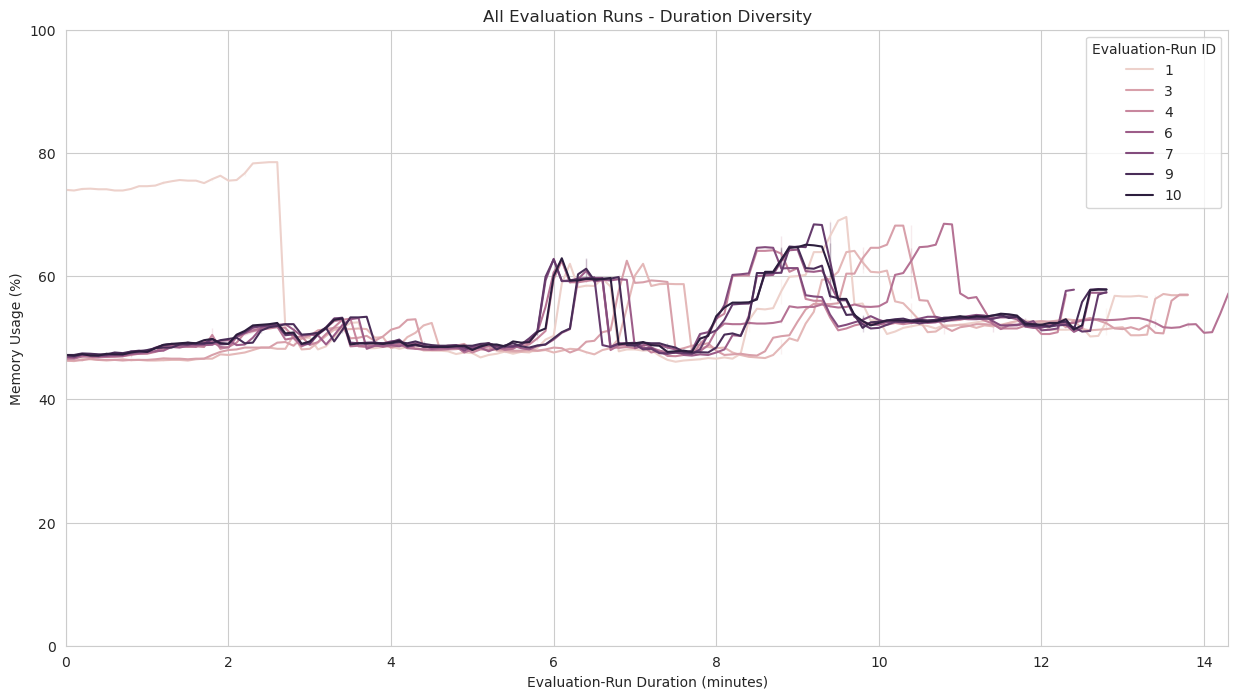

In [21]:
draw_line_graph_with_all_runs(
    data=df,
    y_label="Memory Usage (%)",
    key=MEMORY_KEY,
    )

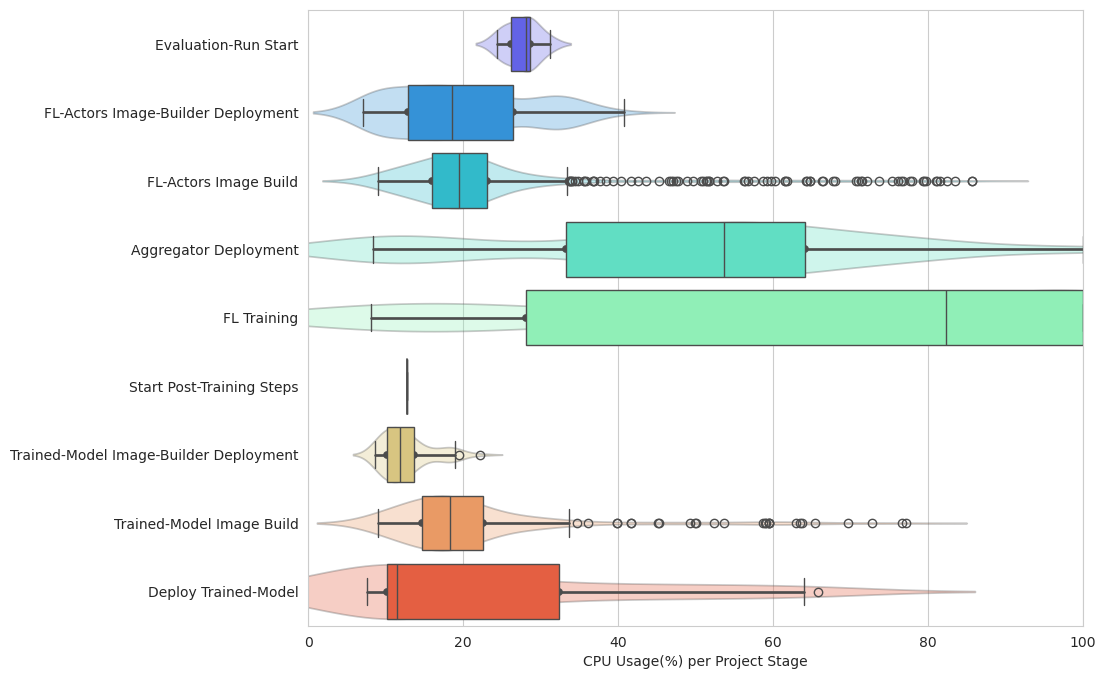

In [22]:
draw_box_violin_plot_for_each_stage(
    data=df,
    key=CPU_KEY,
    x_label="CPU Usage(%) per Project Stage",
)

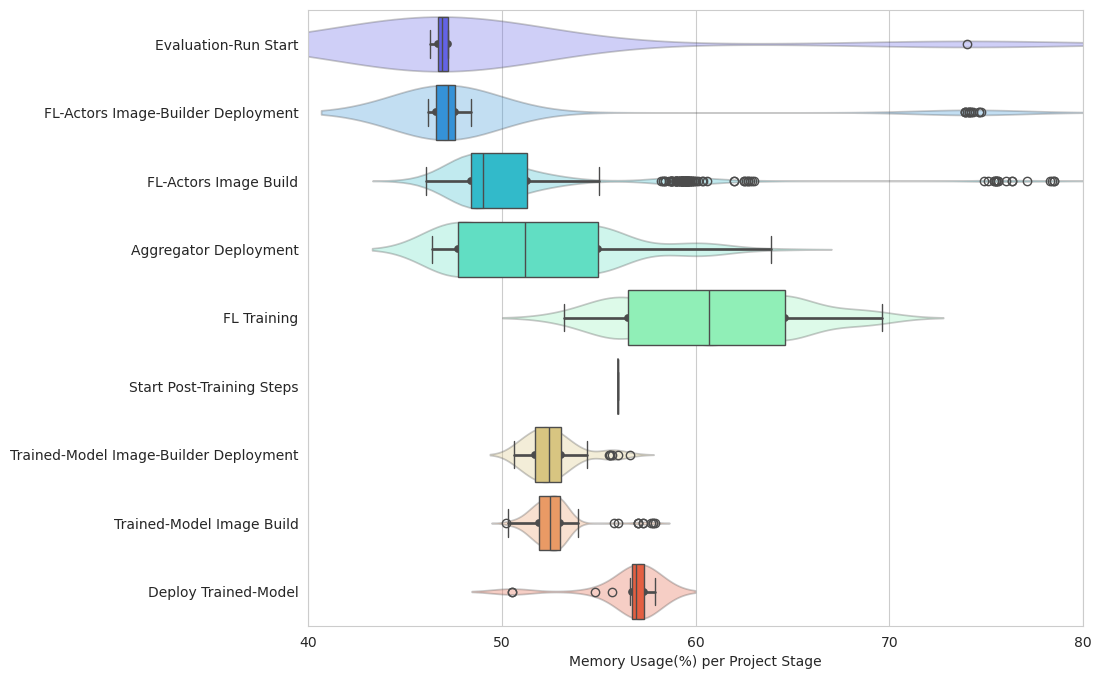

In [23]:
draw_box_violin_plot_for_each_stage(
    data=df,
    key=MEMORY_KEY,
    x_label="Memory Usage(%) per Project Stage",
    x_lim=(40,80),
)

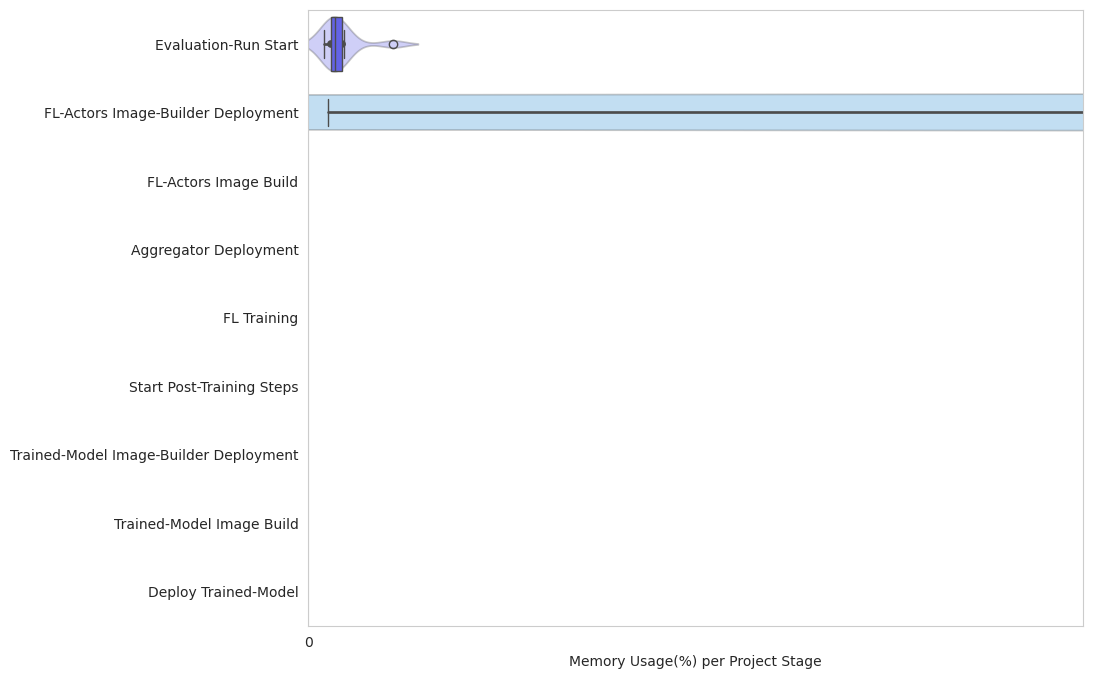

In [80]:
draw_box_violin_plot_for_each_stage(
    data=df,
    key=DISK_LAST_KEY,
    x_label="Memory Usage(%) per Project Stage",
    #x_lim=(40,80),
)

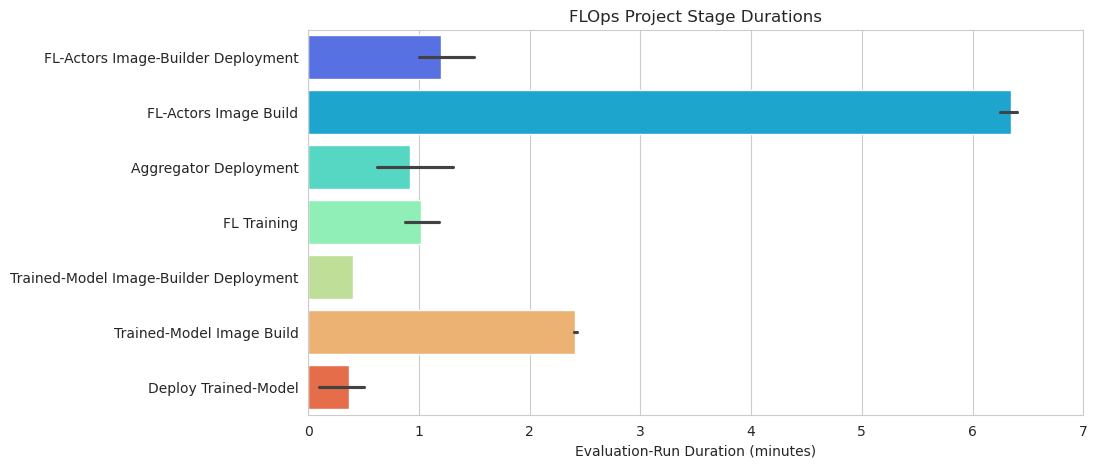

In [24]:
_data = get_stage_durations_df(df)
draw_graph(
    data=_data,
    plot_functions=[
        lambda: sns.barplot(
            data=_data,
            x=STAGE_DURATIONS_KEY,
            y=STAGE_KEY,
            palette=PALETTE,
            hue=STAGE_KEY,
        )
    ],
    title="FLOps Project Stage Durations",
)


### Disk Space Changes

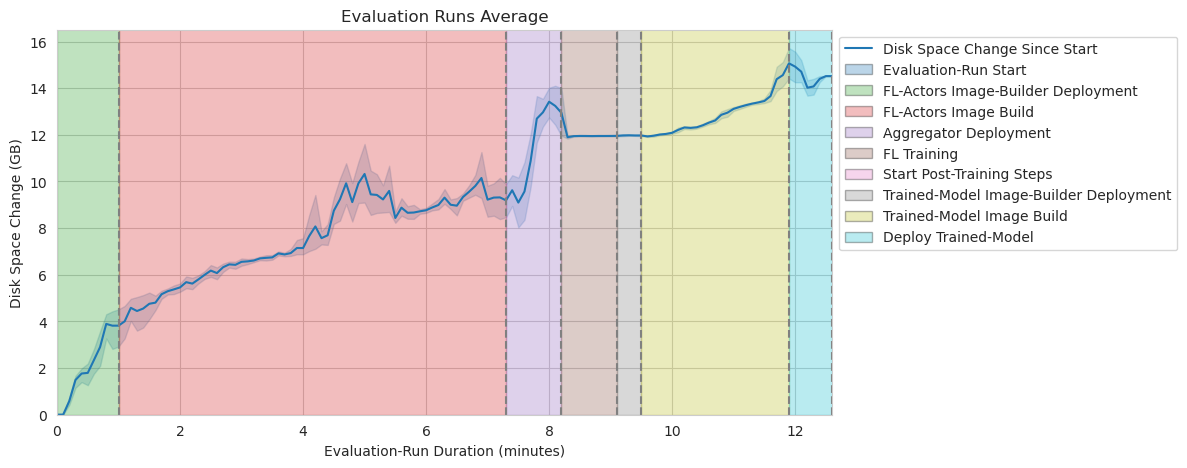

In [37]:
_normalized_df = normalized_df.copy()
_normalized_df[[DISK_START_KEY]] = _normalized_df[[DISK_START_KEY]] / 1024

draw_graph(
    title="Evaluation Runs Average",
    data=_normalized_df[[DISK_START_KEY, STAGE_KEY, RUN_ID_KEY]],
    plot_functions=[
        lambda: sns.lineplot(data=_normalized_df[[DISK_START_KEY, STAGE_KEY]])
    ],
    y_label="Disk Space Change (GB)",
    x_lim=(0, max(_normalized_df.index)),
    y_lim=0,
    show_stages=True,
    use_median_stages=True,
)

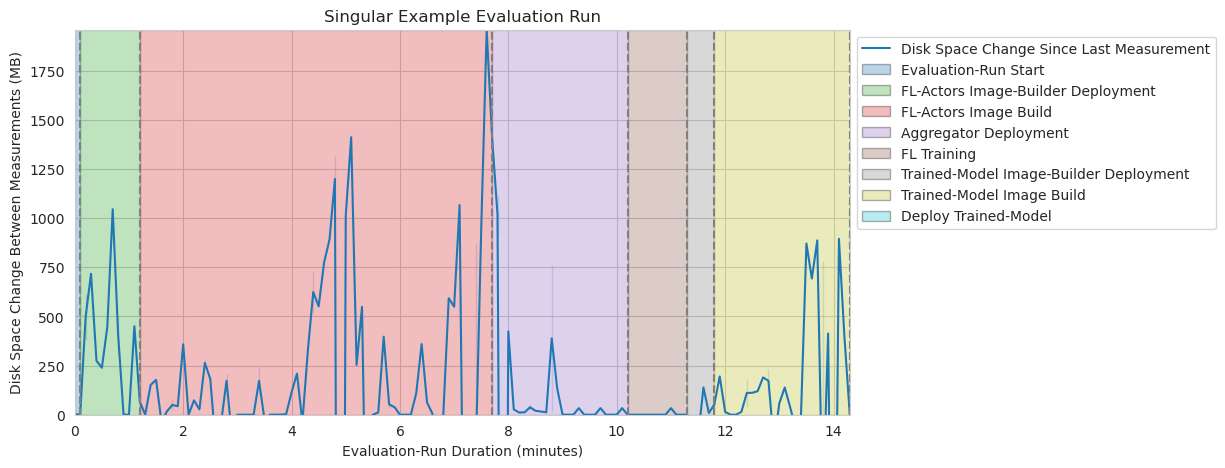

In [27]:

max_y = singular_run_df[DISK_LAST_KEY].max()
draw_graph(
    title="Singular Example Evaluation Run",
    data=singular_run_df[[DISK_LAST_KEY, STAGE_KEY]],
    y_label="Disk Space Change Between Measurements (MB)",
    x_lim=(0, max(singular_run_df.index)),
    show_stages=True,
    stages_color_height=max_y,
    y_lim=(0, max_y)
)

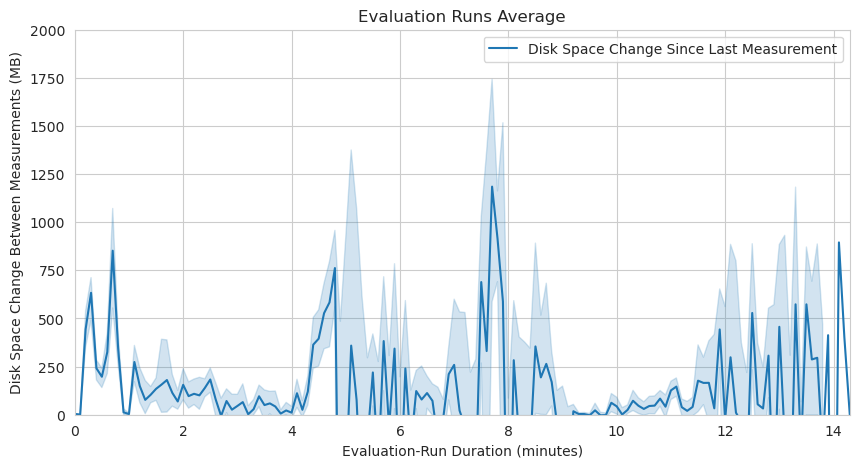

In [28]:
max_y = df[DISK_LAST_KEY].max()
draw_graph(
    title="Evaluation Runs Average",
    data=df[[DISK_LAST_KEY, STAGE_KEY]],
    y_label="Disk Space Change Between Measurements (MB)",
    x_lim=(0, max(df.index)),
    #y_lim=(0, max_y),
    y_lim=(0, 2000),
    #show_stages=True,
    #stages_color_intensity=0.01,
)

### Network

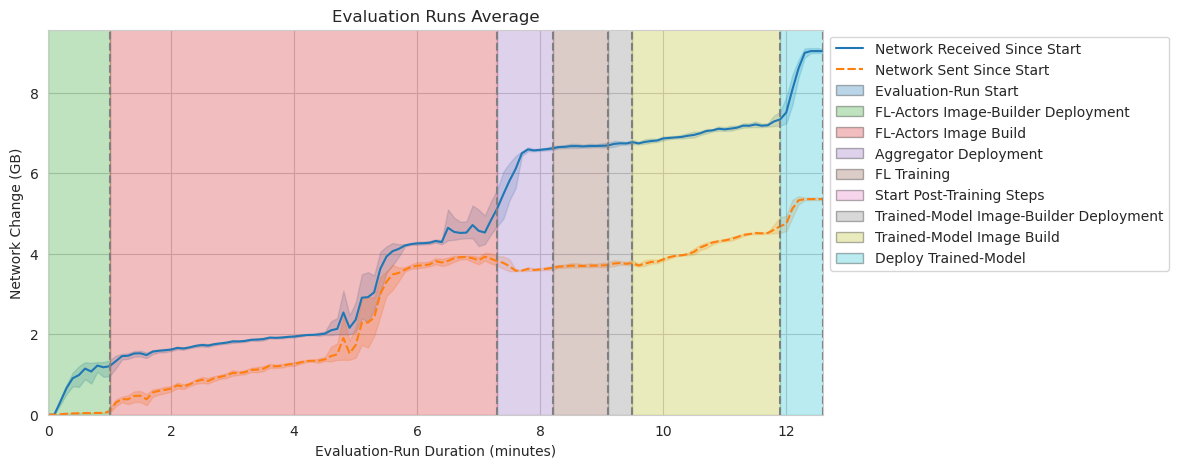

In [40]:
_normalized_df = normalized_df.copy()
_normalized_df[NETWORK_START_KEYS] = _normalized_df[NETWORK_START_KEYS] / 1024

draw_graph(
    title="Evaluation Runs Average",
    data=_normalized_df[NETWORK_START_KEYS + [STAGE_KEY, RUN_ID_KEY]],
    plot_functions=[
        lambda: sns.lineplot(data=_normalized_df[NETWORK_START_KEYS + [STAGE_KEY]])
    ],
    y_label="Network Change (GB)",
    x_lim=(0, max(_normalized_df.index)),
    y_lim=0,
    show_stages=True,
    use_median_stages=True,
)

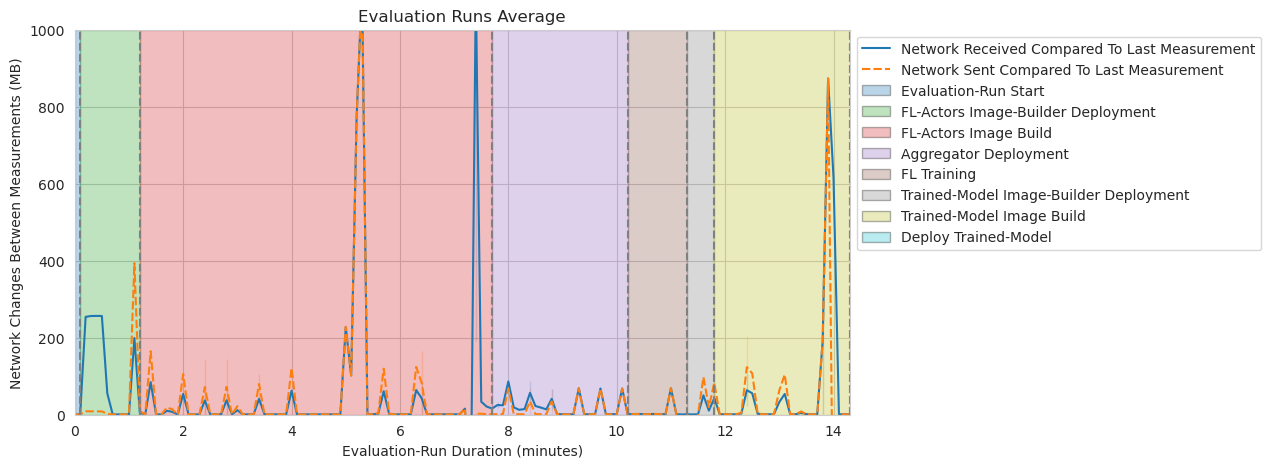

In [31]:
draw_graph(
    title="Evaluation Runs Average",
    data=singular_run_df[NETWORK_LAST_KEYS + [STAGE_KEY]],
    y_label="Network Changes Between Measurements (MB)",
    x_lim=(0, max(singular_run_df.index)),
    y_lim=(0, 1000),
    show_stages=True,
    stages_color_height=1000
)

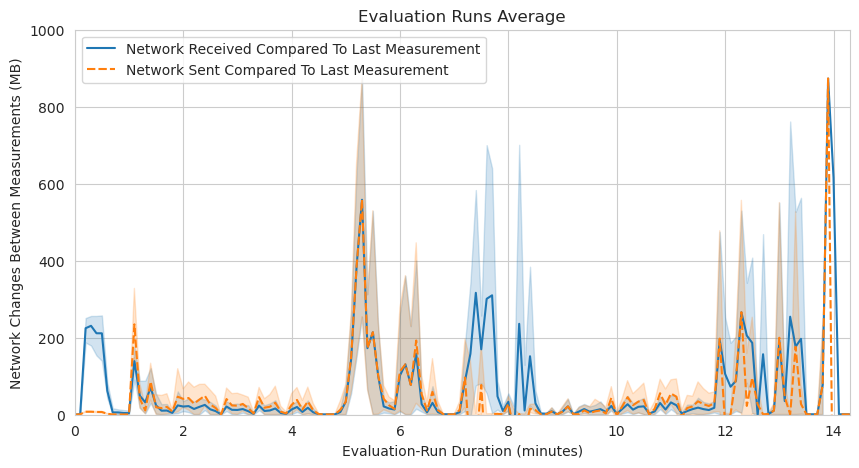

In [32]:
draw_graph(
    title="Evaluation Runs Average",
    data=df[NETWORK_LAST_KEYS + [STAGE_KEY]],
    y_label="Network Changes Between Measurements (MB)",
    x_lim=(0, max(df.index)),
    y_lim=(0, 1000),
    #show_stages=True,
    #stages_color_intensity=0.01,
)

### Trained Models

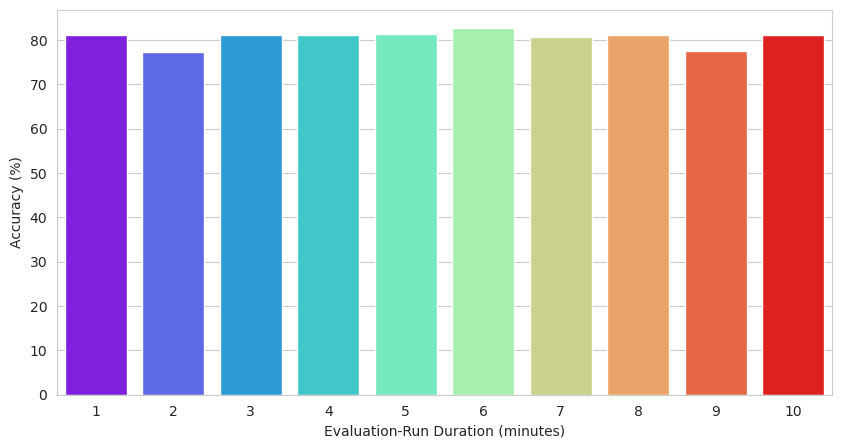

In [79]:
draw_trained_model_comparison_graph(
    data=trained_model_df,
    key=ACCURACY_KEY,
    y_label="Accuracy (%)"
)

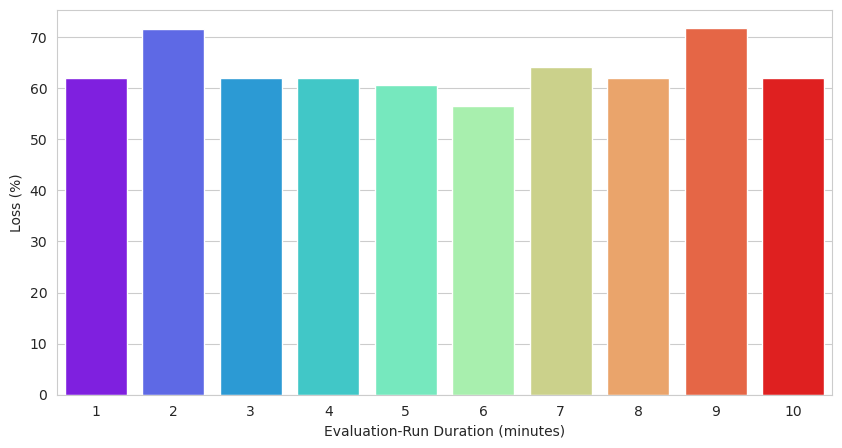

In [69]:
draw_trained_model_comparison_graph(
    data=trained_model_df,
    key=LOSS_KEY,
    y_label="Loss (%)"
)